In [36]:
!pip install cdifflib



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [66]:
from cdifflib import CSequenceMatcher
import json

def get_close_matches_indexes2(phrase, ayat_arr, ayat_info):
    result = []
    s = CSequenceMatcher()
    s.set_seq2(phrase)
    corpus =  " ".join(ayat_arr)
    current_ayat = 0
    char_count = 0
    current_ratio = 0

    for x in range(0, len(corpus)-len(phrase), 1):
        test_phrase = corpus[x: x+len(phrase)]
        s.set_seq1(test_phrase)
        
        temp_ratio = s.ratio()
        if current_ratio < temp_ratio:
            result.append((temp_ratio, x))
            current_ratio = temp_ratio

    score, x1 = result[-1]
    

    while char_count < start_x1:
        char_count += len(ayat_arr[current_ayat])
        current_ayat += 1
    
    idx = current_ayat
    end_idx = idx
    target_char_count = char_count + len(phrase)
    char_x = char_count

    while char_x < target_char_count:
        char_x += len(ayat_arr[end_idx])
        end_idx += 1
        

    return score, ayat_info[idx], ayat_info[end_idx]



def get_close_matches_indexes2(phrase, ayat_arr, ayat_info):
    result = []
    s = CSequenceMatcher()
    s.set_seq2(phrase)
    corpus =  " ".join(ayat_arr)
    current_ayat = 0
    char_count = 0
    current_ratio = 0

    for x in range(0, len(corpus)-len(phrase), len(phrase)):
        test_phrase = corpus[x: x+len(phrase)]
        s.set_seq1(test_phrase)
        
        temp_ratio = s.ratio()
        if current_ratio < temp_ratio:
            result.append((temp_ratio, x))
            current_ratio = temp_ratio

    score, x1 = result[-1]
    
    start_x1 = x1 - len(phrase)
    end_x1 = x1 + len(phrase)
    
    if start_x1 <= 0:
        start_x1 = 0

    if end_x1 >= len(corpus)-len(phrase):
        end_x1 = len(corpus)-len(phrase)

    current_ayat = 0
    char_count = 0

    while char_count < start_x1:
        char_count += len(ayat_arr[current_ayat])
        current_ayat += 1

    for x in range(x1 - len(phrase), len(corpus)-len(phrase), 1):
        test_phrase = corpus[x: x+len(phrase)]
        s.set_seq1(test_phrase)
        
        temp_ratio = s.ratio()
        if current_ratio < temp_ratio:
            result.append((temp_ratio, current_ayat, x))
            current_ratio = temp_ratio

    score, idx, x1 = result[-1]

    end_idx = idx
    target_char_count = char_count + len(phrase)
    char_x = char_count

    while char_x < target_char_count:
        char_x += len(ayat_arr[end_idx])
        end_idx += 1
        

    return score, ayat_info[idx], ayat_info[end_idx]

def get_compiled_quran(quran_fn):
    quranjson = json.load(open(quran_fn, "r", encoding="utf-8"))
    ayat_arr = []
    ayat_info = []
    for surah in quranjson:
        surah_name = surah["transliteration"]
        for ayat in surah["verses"]:
            ayat_info.append({
                "surah_name": surah_name,
                "ayat_number": ayat["id"],
            })
            ayat_arr.append(ayat["text"])
    return ayat_arr, ayat_info


    

In [45]:
ayat_arr, ayat_info = get_compiled_quran("../assets/quran.json")

In [7]:


sum([len(x) for x in ayat_arr])

700236

In [11]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

from transformers import WhisperForConditionalGeneration, WhisperProcessor
stt_model = WhisperForConditionalGeneration.from_pretrained("../whisper-base-ar-quran").to(device)
processor = WhisperProcessor.from_pretrained("../whisper-base-ar-quran")

print("Model loaded")
# Set the model to evaluation mode
stt_model.eval()


Model loaded


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 512)
      (layers): ModuleList(
        (0-5): 6 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=False)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (fin

In [28]:
import librosa
import soundfile as sf
import json
import re 
import numpy as np


audio_file = "../Muddathir - Imran.m4a"

audio_data, sr = librosa.load(audio_file)
audio_data = librosa.resample(audio_data, orig_sr = sr, target_sr=16000)

inputs = processor.feature_extractor(audio_data, return_tensors="pt", sampling_rate=16_000).input_features.to(device)
predicted_ids = stt_model.generate(inputs, max_length=480_000)
decoded_ids = processor.tokenizer.batch_decode(predicted_ids)


/var/folders/j_/dc9smlnj1sndvt5x192t9s080000gn/T/ipykernel_54508/1209537577.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(audio_file)
/opt/homebrew/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [58]:
print(decoded_ids)
tarteel_string = re.sub(r'<[^>]*>', '', decoded_ids[0])
print()
print(tarteel_string)

['<|startoftranscript|><|ar|><|transcribe|><|notimestamps|>أَوْلُوا بِاللَّهِ الْحِكَرَةِ إِلَى رَهْمَ الْرَحِيمِ يَا أَيُّهَا مُدَّفِّرٌ كُمْ فَأَنْذِرْ وَيَقْتَفَ كَبِّرْ فَثْيَابَكَ فَتَفْكِرْ فَيُجْزَ فَاحْجِرْ وَلَا تَمْنُنْ تَسْتَفْسِرْ وَلِرَبِّكَ فَاصْبِرْ فَإِذَا نُقِرَ فِي النَّاقُورِ فَذَلِكَ يَوْمَئِذٍ يَوْمَ نَصِيرٍ عَلَى الْكَافِرِينَ<|endoftext|>']

أَوْلُوا بِاللَّهِ الْحِكَرَةِ إِلَى رَهْمَ الْرَحِيمِ يَا أَيُّهَا مُدَّفِّرٌ كُمْ فَأَنْذِرْ وَيَقْتَفَ كَبِّرْ فَثْيَابَكَ فَتَفْكِرْ فَيُجْزَ فَاحْجِرْ وَلَا تَمْنُنْ تَسْتَفْسِرْ وَلِرَبِّكَ فَاصْبِرْ فَإِذَا نُقِرَ فِي النَّاقُورِ فَذَلِكَ يَوْمَئِذٍ يَوْمَ نَصِيرٍ عَلَى الْكَافِرِينَ


In [57]:
len(tarteel_string)

291

In [59]:
quran_all =  " ".join(ayat_arr)
quran_len = len(quran_all)
tarteel_string_len = len(tarteel_string)

test_strings = []

for x in range(len(quran_all)-len(tarteel_string)):
    test_strings.append(quran_all[x: x+len(tarteel_string)])


In [60]:
len(test_strings)

706180

In [67]:
result = get_close_matches_indexes(tarteel_string, ayat_arr, ayat_info)


In [65]:
print(result)

(0.21993127147766323, {'surah_name': 'Al-Baqarah', 'ayat_number': 182}, {'surah_name': 'Al-Baqarah', 'ayat_number': 185})


In [35]:
test_strings[677763]

'أَنذِرۡ وَرَبَّكَ فَكَبِّرۡ وَثِيَابَكَ فَطَهِّرۡ وَٱلرُّجۡزَ فَٱهۡجُرۡ وَلَا تَمۡنُن تَسۡتَكۡثِرُ وَلِرَبِّكَ فَٱصۡبِرۡ فَإِذَا نُقِرَ فِي ٱلنَّاقُورِ فَذَٰلِكَ يَوۡمَئِذٖ يَوۡمٌ عَسِيرٌ عَلَى ٱلۡكَٰفِرِينَ غَيۡرُ يَسِيرٖ ذَرۡنِي وَمَنۡ خَلَقۡتُ وَحِيدٗا وَجَعَلۡتُ لَهُۥ مَالٗا مَّمۡدُودٗا'

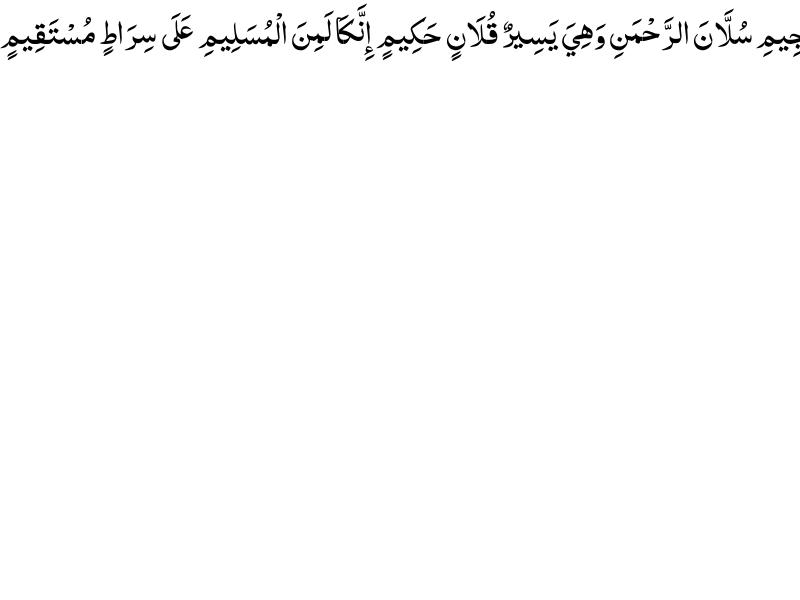

In [17]:
import re

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
blank_image = Image.new('RGB', (800, 600), (255,255,255))
drawing_on_img = ImageDraw.Draw(blank_image)
font = ImageFont.truetype('../assets/Al Majeed Quranic Font_shiped.ttf',size=35)
text_color = (201,50,250)
text_coordinates = (0,0)
drawing_on_img.text(text_coordinates,tarteel_string,font=font,fill='black')
blank_image.save("text_on_test_imager.jpg")
display(Image.open("text_on_test_imager.jpg"))# /content/

